In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# corrected path: 'cloud-cost-leakage' (singular) matches workspace folder
csv_path = r"C:/Users/arpit/OneDrive/Desktop/cloud-cost-leakage/data/processed/cloud_billing_synthetic.csv"
print('Checking file exists at:', csv_path)
print('exists =', os.path.exists(csv_path))
df = pd.read_csv(csv_path, parse_dates=["date"])
df.head()


Checking file exists at: C:/Users/arpit/OneDrive/Desktop/cloud-cost-leakage/data/processed/cloud_billing_synthetic.csv
exists = True


,date,service_name,cost,resource_id,region,usage_amount
0,2023-01-05,Automation,0.081771,automation-8270,asia-south-1,22.776161
1,2023-01-05,Azure DNS,40.914076,azure-dns-1860,eu-west-1,26.420740
2,2023-01-05,Bandwidth,10447.971390,bandwidth-6390,asia-south-1,357.449100
3,2023-01-05,Storage,10998.601240,storage-6191,us-east-1,322.722202
4,2023-01-05,Virtual Machines,4543.884576,virtual-machines-6734,eu-west-1,97.460387


In [3]:
daily_cost = (
    df.groupby("date")["cost"]
    .sum()
    .reset_index()
    .sort_values("date")
)

daily_cost.head()


,date,cost
0,2023-01-05,29838.930640
1,2023-01-06,25689.378854
2,2023-01-07,26660.510272
3,2023-01-08,29132.700148
4,2023-01-09,29901.843107


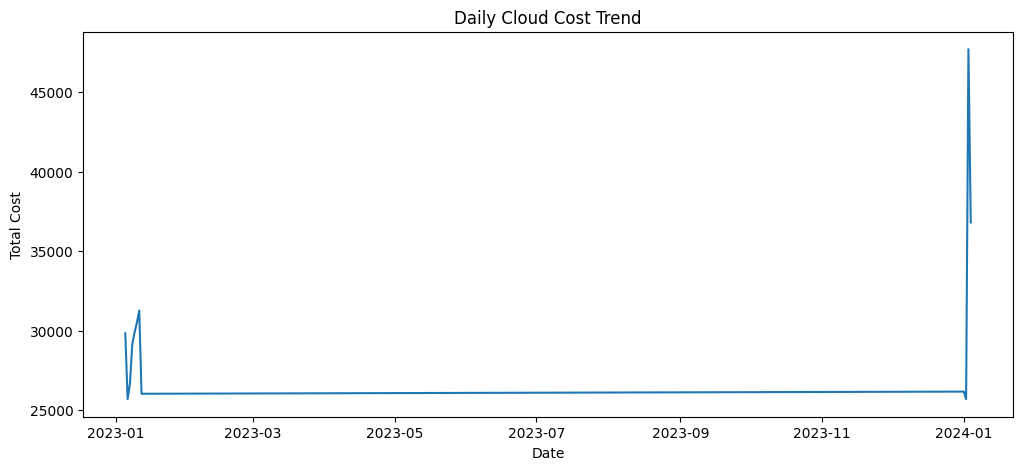

In [4]:
plt.figure(figsize=(12,5))
plt.plot(daily_cost["date"], daily_cost["cost"])
plt.title("Daily Cloud Cost Trend")
plt.xlabel("Date")
plt.ylabel("Total Cost")
plt.show()


In [5]:
daily_cost["rolling_mean"] = daily_cost["cost"].rolling(window=7, min_periods=3).mean()
daily_cost["rolling_std"] = daily_cost["cost"].rolling(window=7, min_periods=3).std()


In [7]:
daily_cost["z_score"] = (
    (daily_cost["cost"] - daily_cost["rolling_mean"]) /
    daily_cost["rolling_std"]
)

spikes = daily_cost[daily_cost["z_score"] > 2]
spikes


,date,cost,rolling_mean,rolling_std,z_score
10,2024-01-03,47714.714723,31039.360563,7716.033822,2.16113


In [8]:
def explain_spike(spike_date, df):
    # Cost on spike day
    spike_day = df[df["date"] == spike_date]

    # Baseline: previous 7 days
    baseline = df[
        (df["date"] < spike_date) &
        (df["date"] >= spike_date - pd.Timedelta(days=7))
    ]

    spike_cost = spike_day.groupby("service_name")["cost"].sum()
    baseline_cost = baseline.groupby("service_name")["cost"].mean()

    explanation = (
        spike_cost.to_frame("spike_cost")
        .join(baseline_cost.to_frame("baseline_cost"))
        .fillna(0)
    )

    explanation["delta"] = explanation["spike_cost"] - explanation["baseline_cost"]

    return explanation.sort_values("delta", ascending=False)


In [14]:
if len(spikes) > 0:
    test_date = spikes.iloc[0]["date"]
    expl = explain_spike(test_date, df).head(5)
    # explicitly display the dataframe in notebook output
    from IPython.display import display
    display(expl)
else:
    print('No spikes found. spikes count =', len(spikes))


,spike_cost,baseline_cost,delta
service_name,,,
Backup,19144.324258,19.287668,19125.036590
Storage,12218.004130,10672.706100,1545.298030
Bandwidth,11556.712800,10527.781275,1028.931525
Virtual Network,2287.114918,2215.353514,71.761405
Virtual Machines Licenses,2466.692294,2397.065868,69.626426


In [ ]:
def human_explanation(spike_date, explanation_df):
    top = explanation_df.head(2)
    text = f"On {spike_date.date()}, cloud costs spiked mainly due to "

    reasons = []
    for service, row in top.iterrows():
        reasons.append(
            f"{service} (increase of {row['delta']:.0f})"
        )

    return text + " and ".join(reasons) + "."

human_explanation(test_date, explain_spike(test_date, df))
